<a href="https://colab.research.google.com/github/DanielWill-1/Adaptive-FSL-defect-detection-system-CIS/blob/main/Few_Shot_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "archive (1).zip"


Archive:  archive (1).zip
  inflating: NEU-DET/train/annotations/crazing_1.xml  
  inflating: NEU-DET/train/annotations/crazing_10.xml  
  inflating: NEU-DET/train/annotations/crazing_100.xml  
  inflating: NEU-DET/train/annotations/crazing_101.xml  
  inflating: NEU-DET/train/annotations/crazing_102.xml  
  inflating: NEU-DET/train/annotations/crazing_103.xml  
  inflating: NEU-DET/train/annotations/crazing_104.xml  
  inflating: NEU-DET/train/annotations/crazing_105.xml  
  inflating: NEU-DET/train/annotations/crazing_106.xml  
  inflating: NEU-DET/train/annotations/crazing_107.xml  
  inflating: NEU-DET/train/annotations/crazing_108.xml  
  inflating: NEU-DET/train/annotations/crazing_109.xml  
  inflating: NEU-DET/train/annotations/crazing_11.xml  
  inflating: NEU-DET/train/annotations/crazing_110.xml  
  inflating: NEU-DET/train/annotations/crazing_111.xml  
  inflating: NEU-DET/train/annotations/crazing_112.xml  
  inflating: NEU-DET/train/annotations/crazing_113.xml  
  inflati

In [ ]:
!ls


'archive (1).zip'   dataset   NEU-DET   sample_data


In [ ]:
!ls NEU-DET


train  validation


In [ ]:
!ls NEU-DET/train


annotations  images


In [ ]:
import os

TARGET = "dataset"
classes = ["crazing", "inclusion", "patches", "pitted_surface", "rolled_in_scale", "scratches"]

for split in ["train", "val"]:
    for cls in classes:
        os.makedirs(f"{TARGET}/{split}/{cls}", exist_ok=True)

print("Target class folders created!")


Target class folders created!


In [ ]:
import os
import shutil

SOURCE_TRAIN = "NEU-DET/train/images"
SOURCE_VAL = "NEU-DET/validation/images" # Corrected from 'NEU-DET/val/images'
TARGET = "dataset"

classes = ["crazing", "inclusion", "patches", "pitted_surface", "rolled_in_scale", "scratches"]

def sort_images(source_folder, split_name):
    for img_name in os.listdir(source_folder):
        img_path = os.path.join(source_folder, img_name)

        # Check if the current entry is a file before attempting to copy
        if os.path.isfile(img_path):
            img_lower = img_name.lower()

            matched = False
            for cls in classes:
                key = cls.replace("_", "")
                if key in img_lower:
                    shutil.copy(
                        img_path,
                        f"{TARGET}/{split_name}/{cls}/{img_name}"
                    )
                    matched = True
                    break

            if not matched:
                print("Could not classify:", img_name)
        # else: # Optional: Uncomment to see skipped directories
        #     print(f"Skipping directory: {img_path}")

# Sort images
sort_images(SOURCE_TRAIN, "train")
sort_images(SOURCE_VAL, "val")

print("Sorting complete!")

Sorting complete!


In [ ]:
!ls dataset/train


crazing  inclusion  patches  pitted_surface  rolled_in_scale  scratches


In [ ]:
for cls in ["crazing","inclusion","patches","pitted_surface","rolled_in_scale","scratches"]:
    print(cls, "train:", len(os.listdir(f"dataset/train/{cls}")),
                "val:", len(os.listdir(f"dataset/val/{cls}")))


crazing train: 0 val: 0
inclusion train: 0 val: 0
patches train: 0 val: 0
pitted_surface train: 0 val: 0
rolled_in_scale train: 0 val: 0
scratches train: 0 val: 0


In [ ]:
!pip install timm


In [ ]:
import os
import random
import torch
import timm
from PIL import Image
from torchvision import transforms

# =========================
# SETTINGS
# =========================
DATASET_PATH = "dataset"
IMAGE_SIZE = 224
N_WAY = 3
K_SHOT = 2
EPISODES = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

# =========================
# IMAGE TRANSFORM
# =========================
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# =========================
# LOAD MODEL
# =========================
print("Loading Swin Transformer...")
model = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=0
).to(DEVICE)
model.eval()

# =========================
# LOAD DATA
# =========================
def load_split(split_name):
    data = {}
    split_path = os.path.join(DATASET_PATH, split_name)

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)

        if os.path.isdir(cls_path):
            images = [
                os.path.join(cls_path, f)
                for f in os.listdir(cls_path)
                if f.lower().endswith(tuple([".jpg", ".png", ".jpeg"]))
            ]

            if len(images) >= K_SHOT + 1:
                data[cls] = images

    return data

train_data = load_split("train")
val_data = load_split("val")

print("Train classes:", train_data.keys())
print("Val classes:", val_data.keys())

# --- FIX: Add check for sufficient classes before running evaluation ---
if len(train_data) < N_WAY:
    print(f"Error: Not enough classes in training data ({len(train_data.keys())} found, {N_WAY} required for N_WAY).")
    print("Please ensure your 'dataset/train' directory is correctly populated with class subfolders, each containing at least K_SHOT + 1 images.")
elif len(val_data) < N_WAY:
    print(f"Error: Not enough classes in validation data ({len(val_data.keys())} found, {N_WAY} required for N_WAY).")
    print("Please ensure your 'dataset/val' directory is correctly populated with class subfolders, each containing at least K_SHOT + 1 images.")
else:
    # =========================
    # FEATURE EXTRACTOR
    # =========================
    def extract_features(image_path):
        img = Image.open(image_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            features = model(img)

        return features.squeeze(0)

    # =========================
    # CREATE PROTOTYPES
    # =========================
    def create_prototypes(selected_classes):
        prototypes = {}

        for cls in selected_classes:
            support_images = random.sample(train_data[cls], K_SHOT)
            features = []

            for img_path in support_images:
                features.append(extract_features(img_path))

            prototype = torch.stack(features).mean(0)
            prototypes[cls] = prototype

        return prototypes

    # =========================
    # PREDICTION
    # =========================
    def predict(query_image, prototypes):
        query_feature = extract_features(query_image)

        best_class = None
        best_distance = float("inf")

        for cls, proto in prototypes.items():
            distance = torch.norm(query_feature - proto)

            if distance < best_distance:
                best_distance = distance
                best_class = cls

        return best_class

    # =========================
    # EVALUATE
    # =========================
    def evaluate():
        correct = 0

        for i in range(EPISODES):
            class_list = list(train_data.keys())
            selected_classes = random.sample(class_list, N_WAY)

            prototypes = create_prototypes(selected_classes)

            true_class = random.choice(selected_classes)
            query_image = random.choice(val_data[true_class])

            prediction = predict(query_image, prototypes)

            if prediction == true_class:
                correct += 1

            print(f"Episode {i+1}/{EPISODES} | True: {true_class} | Predicted: {prediction}")

        accuracy = (correct / EPISODES) * 100
        print("\n======================")
        print(f"Final Accuracy: {accuracy:.2f}%")
        print("======================")

    # =========================
    # RUN
    # =========================
    evaluate()

Using device: cuda
Loading Swin Transformer...
Train classes: dict_keys([])
Val classes: dict_keys([])
Error: Not enough classes in training data (0 found, 3 required for N_WAY).
Please ensure your 'dataset/train' directory is correctly populated with class subfolders, each containing at least K_SHOT + 1 images.


In [ ]:
!ls dataset


train  val


In [ ]:
!ls dataset/train


crazing  inclusion  patches  pitted_surface  rolled_in_scale  scratches


In [ ]:
!find dataset/train -type f | head -n 10


In [ ]:
!ls NEU-DET/train/annotations | head


crazing_100.xml
crazing_101.xml
crazing_102.xml
crazing_103.xml
crazing_104.xml
crazing_105.xml
crazing_106.xml
crazing_107.xml
crazing_108.xml
crazing_109.xml


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

SOURCE_TRAIN_IMG = "NEU-DET/train/images"
SOURCE_TRAIN_ANN = "NEU-DET/train/annotations"

SOURCE_VAL_IMG = "NEU-DET/validation/images"
SOURCE_VAL_ANN = "NEU-DET/validation/annotations"

TARGET = "dataset"

# Class mapping (adjust if needed)
CLASS_MAP = {
    "crazing": "crazing",
    "inclusion": "inclusion",
    "patches": "patches",
    "pitted_surface": "pitted_surface",
    "rolled_in_scale": "rolled_in_scale",
    "rolled-in_scale": "rolled_in_scale", # Added this mapping for consistency
    "scratches": "scratches"
}

# Create target folders
for split in ["train", "val"]:
    for cls in set(CLASS_MAP.values()): # Iterate over unique target classes
        os.makedirs(f"{TARGET}/{split}/{cls}", exist_ok=True)

def get_class_from_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    obj = root.find("object")
    if obj is None:
        return None
    name = obj.find("name")
    if name is None:
        return None
    return name.text.lower().strip()

def sort_images(img_folder, ann_folder, split_name):
    for xml_file in os.listdir(ann_folder):
        if not xml_file.endswith(".xml"):
            continue

        xml_path = os.path.join(ann_folder, xml_file)
        cls_name_from_xml = get_class_from_xml(xml_path)

        if cls_name_from_xml not in CLASS_MAP:
            print("Unknown class:", cls_name_from_xml)
            continue

        target_cls = CLASS_MAP[cls_name_from_xml]

        img_name = xml_file.replace(".xml", ".jpg")
        img_path = os.path.join(img_folder, img_name)

        if not os.path.exists(img_path):
            print("Missing image for:", xml_file)
            continue

        shutil.copy(
            img_path,
            f"{TARGET}/{split_name}/{target_cls}/{img_name}"
        )

# Run sorting
sort_images(SOURCE_TRAIN_IMG, SOURCE_TRAIN_ANN, "train")
sort_images(SOURCE_VAL_IMG, SOURCE_VAL_ANN, "val")

print("XML-based sorting complete!")


Missing image for: crazing_195.xml
Missing image for: patches_142.xml
Missing image for: scratches_92.xml
Missing image for: inclusion_18.xml
Missing image for: scratches_164.xml
Missing image for: crazing_141.xml
Missing image for: crazing_42.xml
Missing image for: inclusion_112.xml
Missing image for: scratches_74.xml
Missing image for: pitted_surface_117.xml
Missing image for: crazing_119.xml
Missing image for: inclusion_120.xml
Missing image for: pitted_surface_157.xml
Missing image for: inclusion_111.xml
Missing image for: pitted_surface_39.xml
Missing image for: crazing_187.xml
Missing image for: crazing_41.xml
Missing image for: rolled-in_scale_228.xml
Missing image for: patches_185.xml
Missing image for: pitted_surface_90.xml
Missing image for: pitted_surface_153.xml
Missing image for: rolled-in_scale_92.xml
Missing image for: scratches_85.xml
Missing image for: patches_64.xml
Missing image for: rolled-in_scale_21.xml
Missing image for: pitted_surface_70.xml
Missing image for: p

In [ ]:
!ls dataset/train | head


crazing
inclusion
patches
pitted_surface
rolled_in_scale
scratches


In [ ]:
!find dataset/train -name "*.jpg" | head -n 10


In [ ]:
!find dataset/train -name "*.xml" | head -n 10


In [ ]:
!find . -name "*.jpg" | head -n 20


./NEU-DET/validation/images/crazing/crazing_285.jpg
./NEU-DET/validation/images/crazing/crazing_260.jpg
./NEU-DET/validation/images/crazing/crazing_241.jpg
./NEU-DET/validation/images/crazing/crazing_277.jpg
./NEU-DET/validation/images/crazing/crazing_242.jpg
./NEU-DET/validation/images/crazing/crazing_288.jpg
./NEU-DET/validation/images/crazing/crazing_299.jpg
./NEU-DET/validation/images/crazing/crazing_286.jpg
./NEU-DET/validation/images/crazing/crazing_246.jpg
./NEU-DET/validation/images/crazing/crazing_276.jpg
./NEU-DET/validation/images/crazing/crazing_248.jpg
./NEU-DET/validation/images/crazing/crazing_265.jpg
./NEU-DET/validation/images/crazing/crazing_263.jpg
./NEU-DET/validation/images/crazing/crazing_269.jpg
./NEU-DET/validation/images/crazing/crazing_268.jpg
./NEU-DET/validation/images/crazing/crazing_249.jpg
./NEU-DET/validation/images/crazing/crazing_256.jpg
./NEU-DET/validation/images/crazing/crazing_296.jpg
./NEU-DET/validation/images/crazing/crazing_255.jpg
./NEU-DET/va

In [ ]:
import os
import shutil
from glob import glob

# Destination folder
os.makedirs("dataset/val/images", exist_ok=True)

# Copy all jpg images from NEU-DET validation
image_paths = glob("NEU-DET/validation/images/*/*.jpg")

print("Total images found:", len(image_paths))

for img in image_paths:
    shutil.copy(img, "dataset/val/images")

print("Copied all validation images successfully!")


Total images found: 360
Copied all validation images successfully!


In [ ]:
import os
import shutil
from glob import glob

# Create destination folder
os.makedirs("dataset/train/images", exist_ok=True)

# Collect all train images
train_paths = glob("NEU-DET/train/images/*/*.jpg")

print("Total train images found:", len(train_paths))

# Copy all images into one folder
for img in train_paths:
    shutil.copy(img, "dataset/train/images")

print("Copied all training images successfully!")



Total train images found: 1440
Copied all training images successfully!


In [ ]:
!find dataset/train/images -name "*.jpg" | head -n 5


dataset/train/images/crazing_151.jpg
dataset/train/images/inclusion_172.jpg
dataset/train/images/patches_185.jpg
dataset/train/images/crazing_71.jpg
dataset/train/images/scratches_146.jpg


In [ ]:
!find NEU-DET/train -name "*.xml" | head -n 10


NEU-DET/train/annotations/crazing_195.xml
NEU-DET/train/annotations/patches_142.xml
NEU-DET/train/annotations/scratches_92.xml
NEU-DET/train/annotations/inclusion_18.xml
NEU-DET/train/annotations/scratches_164.xml
NEU-DET/train/annotations/crazing_141.xml
NEU-DET/train/annotations/crazing_42.xml
NEU-DET/train/annotations/inclusion_112.xml
NEU-DET/train/annotations/scratches_74.xml
NEU-DET/train/annotations/pitted_surface_117.xml


In [ ]:
!find NEU-DET/validation -name "*.xml" | head -n 10


NEU-DET/validation/annotations/crazing_253.xml
NEU-DET/validation/annotations/crazing_258.xml
NEU-DET/validation/annotations/patches_248.xml
NEU-DET/validation/annotations/scratches_266.xml
NEU-DET/validation/annotations/crazing_274.xml
NEU-DET/validation/annotations/inclusion_291.xml
NEU-DET/validation/annotations/pitted_surface_297.xml
NEU-DET/validation/annotations/pitted_surface_243.xml
NEU-DET/validation/annotations/pitted_surface_291.xml
NEU-DET/validation/annotations/rolled-in_scale_278.xml


In [ ]:
!find NEU-DET/train -name "*.xml" | head -n 5

NEU-DET/train/annotations/crazing_195.xml
NEU-DET/train/annotations/patches_142.xml
NEU-DET/train/annotations/scratches_92.xml
NEU-DET/train/annotations/inclusion_18.xml
NEU-DET/train/annotations/scratches_164.xml


In [ ]:
import os
import xml.etree.ElementTree as ET

# Class names (6 defects)
classes = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled-in_scale",
    "scratches"
]

# Convert VOC bbox → YOLO bbox
def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]

    x_center = (box[0] + box[1]) / 2.0
    y_center = (box[2] + box[3]) / 2.0

    w = box[1] - box[0]
    h = box[3] - box[2]

    return (x_center * dw, y_center * dh, w * dw, h * dh)

# Convert one XML file
def convert_xml(xml_file, output_label_folder):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    image_id = filename.replace(".jpg", "")

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    label_path = os.path.join(output_label_folder, image_id + ".txt")

    with open(label_path, "w") as out_file:
        for obj in root.findall("object"):
            cls = obj.find("name").text

            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            xmax = float(xml_box.find("xmax").text)
            ymin = float(xml_box.find("ymin").text)
            ymax = float(xml_box.find("ymax").text)

            bb = convert_bbox((w, h), (xmin, xmax, ymin, ymax))

            out_file.write(f"{cls_id} " +
                           " ".join([str(round(a, 6)) for a in bb]) +
                           "\n")

# Convert all annotations in folder
def convert_folder(xml_folder, label_folder):
    os.makedirs(label_folder, exist_ok=True)

    xml_files = [f for f in os.listdir(xml_folder) if f.endswith(".xml")]
    print("Total XML files:", len(xml_files))

    for xml in xml_files:
        convert_xml(os.path.join(xml_folder, xml), label_folder)

    print("Conversion complete for:", xml_folder)


# ===============================
# RUN Conversion for Train + Val
# ===============================

convert_folder("NEU-DET/train/annotations", "dataset/train/labels")
convert_folder("NEU-DET/validation/annotations", "dataset/val/labels")


Total XML files: 1439
Conversion complete for: NEU-DET/train/annotations
Total XML files: 361
Conversion complete for: NEU-DET/validation/annotations


In [ ]:
!find dataset/train/labels -name "*.txt" | head -n 5


dataset/train/labels/pitted_surface_186.txt
dataset/train/labels/scratches_33.txt
dataset/train/labels/scratches_238.txt
dataset/train/labels/rolled-in_scale_61.txt
dataset/train/labels/pitted_surface_67.txt


In [ ]:
!cat dataset/train/labels/crazing_102.txt


0 0.365 0.3875 0.71 0.755
0 0.8725 0.6575 0.245 0.465


In [ ]:
!pip install timm torch torchvision


In [ ]:
import timm
import torch
import torch.nn as nn

class SwinEncoder(nn.Module):
    def __init__(self, model_name="swin_tiny_patch4_window7_224"):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0  # removes classifier head
        )

    def forward(self, x):
        return self.backbone(x)  # embedding vector


In [ ]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class NEUDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.images = os.listdir(image_folder)

        # Class names from file prefix
        self.classes = sorted(list(set([img.split("_")[0] for img in self.images])))

        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        # Label from prefix
        label_name = img_name.split("_")[0]
        label = self.class_to_idx[label_name]

        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [ ]:
train_dataset = NEUDataset("dataset/train/images")
val_dataset   = NEUDataset("dataset/val/images")

print("Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))


Classes: ['crazing', 'inclusion', 'patches', 'pitted', 'rolled-in', 'scratches']
Train images: 1440
Val images: 360


In [ ]:
!pip install timm torch torchvision matplotlib


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import timm
import matplotlib.pyplot as plt


In [ ]:
class NEUDataset:
    def __init__(self, folder):
        self.folder = folder
        self.images = os.listdir(folder)

        # class names from filename prefix
        self.classes = sorted(list(set([img.split("_")[0] for img in self.images])))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def get_image(self, name):
        img_path = os.path.join(self.folder, name)
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)


In [ ]:
train_dataset = NEUDataset("dataset/train/images")
val_dataset   = NEUDataset("dataset/val/images")

print("Classes:", train_dataset.classes)
print("Train Images:", len(train_dataset.images))
print("Val Images:", len(val_dataset.images))


Classes: ['crazing', 'inclusion', 'patches', 'pitted', 'rolled-in', 'scratches']
Train Images: 1440
Val Images: 360


In [ ]:
def create_episode(dataset, n_way=3, k_shot=5, q_query=5):

    selected = random.sample(dataset.classes, n_way)

    support_x, support_y = [], []
    query_x, query_y = [], []

    for i, cls in enumerate(selected):

        cls_imgs = [img for img in dataset.images if img.startswith(cls)]
        chosen = random.sample(cls_imgs, k_shot + q_query)

        support_imgs = chosen[:k_shot]
        query_imgs   = chosen[k_shot:]

        for img in support_imgs:
            support_x.append(dataset.get_image(img))
            support_y.append(i)

        for img in query_imgs:
            query_x.append(dataset.get_image(img))
            query_y.append(i)

    return (
        torch.stack(support_x),
        torch.tensor(support_y),
        torch.stack(query_x),
        torch.tensor(query_y)
    )


In [ ]:
class SwinEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class ProtoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()

    def forward(self, support_x, support_y, query_x):

        support_emb = self.encoder(support_x)
        query_emb   = self.encoder(query_x)

        # Compute Prototypes
        prototypes = []
        for c in torch.unique(support_y):
            proto = support_emb[support_y == c].mean(0)
            prototypes.append(proto)

        prototypes = torch.stack(prototypes)

        # Distance
        dist = torch.cdist(query_emb, prototypes)

        # Logits
        return -dist


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import random
import os
from PIL import Image
from torchvision import transforms
from glob import glob # Added for glob functionality

class SwinEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )

    def forward(self, x):
        return self.model(x)

class ProtoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()

    def forward(self, support_x, support_y, query_x):

        support_emb = self.encoder(support_x)
        query_emb   = self.encoder(query_x)

        # Compute Prototypes
        prototypes = []
        for c in torch.unique(support_y):
            proto = support_emb[support_y == c].mean(0)
            prototypes.append(proto)

        prototypes = torch.stack(prototypes)

        # Distance
        dist = torch.cdist(query_emb, prototypes)

        # Logits
        return -dist

def create_episode(dataset, n_way=3, k_shot=5, q_query=5):

    selected = random.sample(dataset.classes, n_way)

    support_x, support_y = [], []
    query_x, query_y = [], []

    for i, cls in enumerate(selected):

        cls_imgs = [img for img in dataset.images if img.startswith(cls)]
        chosen = random.sample(cls_imgs, k_shot + q_query)

        support_imgs = chosen[:k_shot]
        query_imgs   = chosen[k_shot:]

        for img in support_imgs:
            support_x.append(dataset.get_image(img))
            support_y.append(i)

        for img in query_imgs:
            query_x.append(dataset.get_image(img))
            query_y.append(i)

    return (
        torch.stack(support_x),
        torch.tensor(support_y),
        torch.stack(query_x),
        torch.tensor(query_y)
    )

class NEUDataset:
    def __init__(self, folder):
        self.folder = folder
        # Ensure the directory exists before listing
        if not os.path.isdir(folder):
            raise FileNotFoundError(f"Directory not found: {folder}")
        self.images = os.listdir(folder)

        # class names from filename prefix
        self.classes = sorted(list(set([img.split("_")[0] for img in self.images])))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def get_image(self, name):
        img_path = os.path.join(self.folder, name)
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

# --- Data Preparation (Ensuring directories and files exist) ---
# Create destination folders if they don't exist
os.makedirs("dataset/train/images", exist_ok=True)
os.makedirs("dataset/val/images", exist_ok=True)

# Copy train images if the directory is empty or not fully populated
if not os.listdir("dataset/train/images") or len(os.listdir("dataset/train/images")) < 1000: # Heuristic check
    print("Populating dataset/train/images...")
    train_paths = glob("NEU-DET/train/images/*/*.jpg")
    for img_path in train_paths:
        shutil.copy(img_path, os.path.join("dataset/train/images", os.path.basename(img_path)))
    print(f"Copied {len(os.listdir('dataset/train/images'))} images to dataset/train/images.")

# Copy val images if the directory is empty or not fully populated
if not os.listdir("dataset/val/images") or len(os.listdir("dataset/val/images")) < 300: # Heuristic check
    print("Populating dataset/val/images...")
    val_paths = glob("NEU-DET/validation/images/*/*.jpg")
    for img_path in val_paths:
        shutil.copy(img_path, os.path.join("dataset/val/images", os.path.basename(img_path)))
    print(f"Copied {len(os.listdir('dataset/val/images'))} images to dataset/val/images.")
# --- End Data Preparation ---


train_dataset = NEUDataset("dataset/train/images")
val_dataset   = NEUDataset("dataset/val/images")

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ProtoNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_history = []
acc_history  = []

episodes = 500

for ep in range(episodes):

    support_x, support_y, query_x, query_y = create_episode(train_dataset)

    support_x, support_y = support_x.to(device), support_y.to(device)
    query_x, query_y     = query_x.to(device), query_y.to(device)

    logits = model(support_x, support_y, query_x)

    loss = F.cross_entropy(logits, query_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accuracy
    pred = logits.argmax(1)
    acc = (pred == query_y).float().mean().item()

    # Save for graphs
    loss_history.append(loss.item())
    acc_history.append(acc)

    if ep % 50 == 0:
        print(f"Episode {ep} | Loss: {loss:.4f} | Accuracy: {acc*100:.2f}%")


Episode 0 | Loss: 0.2384 | Accuracy: 100.00%
Episode 50 | Loss: 0.0138 | Accuracy: 100.00%
Episode 100 | Loss: 0.1287 | Accuracy: 93.33%
Episode 150 | Loss: 0.0215 | Accuracy: 100.00%
Episode 200 | Loss: 0.0019 | Accuracy: 100.00%
Episode 250 | Loss: 0.0858 | Accuracy: 93.33%
Episode 300 | Loss: 0.0002 | Accuracy: 100.00%
Episode 350 | Loss: 0.0092 | Accuracy: 100.00%
Episode 400 | Loss: 0.0000 | Accuracy: 100.00%
Episode 450 | Loss: 0.0001 | Accuracy: 100.00%


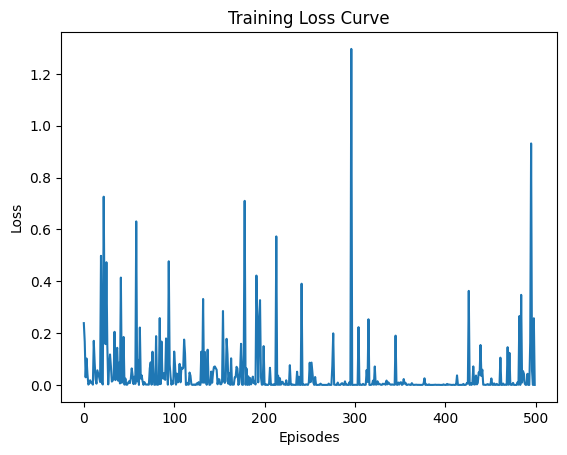

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()


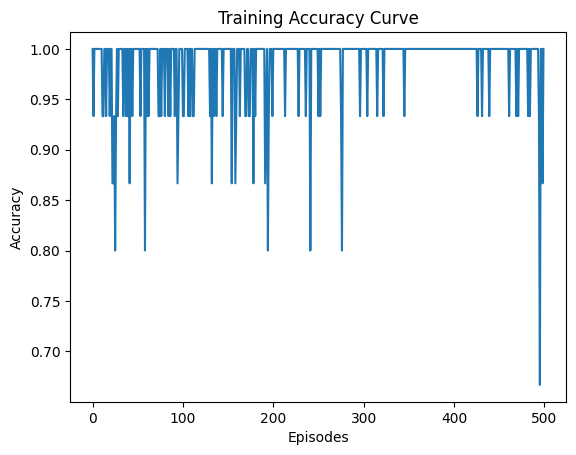

In [ ]:
plt.figure()
plt.plot(acc_history)
plt.title("Training Accuracy Curve")
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
def evaluate(model, dataset, episodes=100):

    model.eval()
    acc_list = []

    with torch.no_grad():
        for _ in range(episodes):

            support_x, support_y, query_x, query_y = create_episode(dataset)

            support_x, support_y = support_x.to(device), support_y.to(device)
            query_x, query_y     = query_x.to(device), query_y.to(device)

            logits = model(support_x, support_y, query_x)

            pred = logits.argmax(1)
            acc = (pred == query_y).float().mean().item()
            acc_list.append(acc)

    return sum(acc_list) / len(acc_list)


In [ ]:
val_acc = evaluate(model, val_dataset)

print("Final Validation Accuracy:", val_acc * 100, "%")


Final Validation Accuracy: 99.73333352804184 %
